Validation of Spin-Flip scattering with gepore.f
=====================================================

We can check a simple magnetic model 
with spin-flip scattering ($(\vec M \nparallel \vec H)$ against:

* gepore.f as written directly in the [PNR book chapter](https://ncnr.nist.gov/programs/reflect/references/pnrchapti.pdf) [1]
* gepore_zeeman.f (a slightly modified version of gepore.f that includes the Zeeman effect)
* refl1d using the magnetic calculation kernel

We are using the Refl1D geometry convention where
$\text{Aguide} = 270^\circ, \theta_M = 270^\circ$ corresponds to an in-plane magnetic field
with $\vec M \parallel \vec H$.
The sample will be a magnetic layer on a non-magnetic substrate, with a non-magnetic cap layer

[1] <cite>Majkrzak, C., O'Donovan, K. & Berk, N. (2006). Neutron Scattering from Magnetic Materials, edited by T. Chatterji, pp. 397–471. Amsterdam: Elsevier Science.</cite>


In [141]:
import numpy as np
from refl1d.validation.gepore_runner import GeporeRunner

# start a GeporeRunner instance

runner = GeporeRunner()

QS = 0.001  # start value of Q
DQ = 0.0004  # step size in Q
NQ = 80  # number of Q points
Qz = np.arange(NQ) * DQ + QS


Define the sample as a list of layers:

_(note that the magnetic layer is rotated 20 degrees wrt. the field)_

| label       | thickness (A) | $\text{SLD}_N$ $(10^{-6}A)$ | $\text{SLD}_M$ $(10^{-6}A)$ | $\theta_{M}$ $(\text{degrees})$ |
|-------------|-----------|-----------------------------|----------------|---------|
| vacuum      | 0         | 0.0                         | 0.0            | 270     |
| mag. layer  | 1000      | 8.0                         | 2.0            | <span style="color:red;font-weight:bold;">250</span>     |
| cap layer   | 500       | 5.0                         | 0.0            | 270     |
| substrate   | 0         | 2.0                         | 0.0            | 270     |

In [142]:
Aguide = 270.0  # guide field in sample plane
layers = [
    # depth rho rhoM thetaM phiM
    [0, 0.0, 0.0, 270, 0],
    [1000, 8.0, 2.0, 250, 0.0],
    [500, 5.0, 0.0, 270, 0.0],
    [0, 2.0, 0.0, 270, 0.0],
]
depth, rhoN, rhoM, thetaM, phiM = list(zip(*layers))


applied field, in Tesla, shouldn't matter for this calculation

In [143]:
H = 0.5

### Calculating with `gepore.f`
The reflectivities are returned from `gepore.f` in the order
$(r_g^{++}, r_g^{+-}, r_g^{-+}, r_g^{--})$

**NOTE** we use a value of $\text{EPS} = -\text{Aguide}$

In [144]:
EPS = -Aguide
rg = runner.run(layers, QS, DQ, NQ, EPS, H, zeeman_corrections=False)
Rg = [np.abs(r) ** 2 for r in rg]

### Calculating with the modified `gepore_zeeman.f`
A version of the original `gepore.f` that includes Zeeman energy corrections

In [145]:
rgz = runner.run(layers, QS, DQ, NQ, EPS, H, zeeman_corrections=True)
Rgz = [np.abs(r) ** 2 for r in rgz]


### Calculating reflectivity using Refl1D
magnetic_amplitude returns cross-sections in order $(r_1^{--}, r_1^{-+}, r_1^{+-}, r_1^{++})$, 
so we need to reverse them here to compare to gepore outputs


In [146]:
from refl1d.sample.reflectivity import magnetic_amplitude, reflectivity_amplitude

r1 = magnetic_amplitude(Qz / 2, depth, rhoN, 0, rhoM, thetaM, 0, Aguide, H)
R1 = np.abs(r1[::-1]) ** 2

### Plots

In [147]:
from matplotlib import pyplot as plt

#### Refl1D vs gepore_zeeman.f

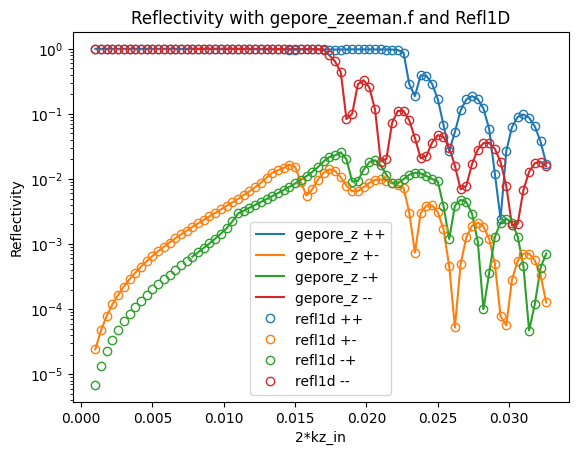

In [148]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs_labels = ["++", "+-", "-+", "--"]
for i, label in enumerate(xs_labels):
    ax.semilogy(Qz, Rgz[i], label=f"gepore_z {label}")
ax.set_prop_cycle(None)
for i, label in enumerate(xs_labels):
    ax.semilogy(Qz, R1[i], "o", label=f"refl1d {label}", fillstyle="none")
ax.set_ylabel("Reflectivity")
ax.set_xlabel("2*kz_in")
ax.set_title("Reflectivity with gepore_zeeman.f and Refl1D")
ax.legend()


The differences between the two reflectivity outputs are small, and are
likely due to differences in the numerical implementation of the
reflectivity calculation.  Here is a plot of the differences:

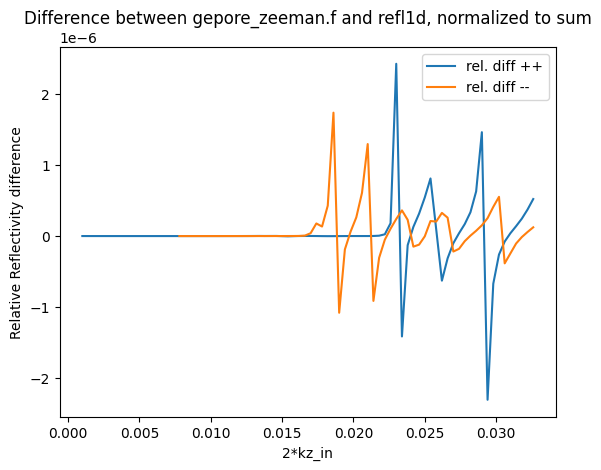

In [149]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs_labels = ["++", "+-", "-+", "--"]
for i, label in enumerate(xs_labels):
    if not i == 1 and not i == 2:  # skip +- and -+
        ax.plot(Qz, 2 * (Rgz[i] - R1[i]) / np.abs(Rgz[i] + R1[i]), label=f"rel. diff {label}")
ax.set_ylabel("Relative Reflectivity difference")
ax.set_xlabel("2*kz_in")
ax.set_title("Difference between gepore_zeeman.f and refl1d, normalized to sum")
ax.legend()

#### Refl1D vs gepore.f

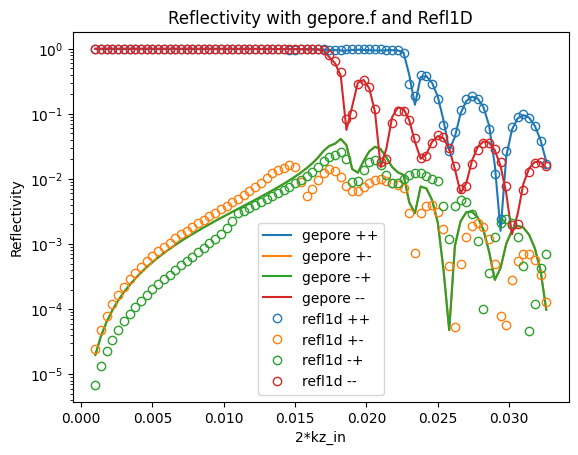

In [150]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs_labels = ["++", "+-", "-+", "--"]
for i, label in enumerate(xs_labels):
    ax.semilogy(Qz, Rg[i], label=f"gepore {label}")
ax.set_prop_cycle(None)
for i, label in enumerate(xs_labels):
    ax.semilogy(Qz, R1[i], "o", label=f"refl1d {label}", fillstyle="none")
ax.set_ylabel("Reflectivity")
ax.set_xlabel("2*kz_in")
ax.set_title("Reflectivity with gepore.f and Refl1D")
ax.legend()

Here the differences are much larger, due to the fact that we are not applying zeeman energy corrections in `gepore.f`

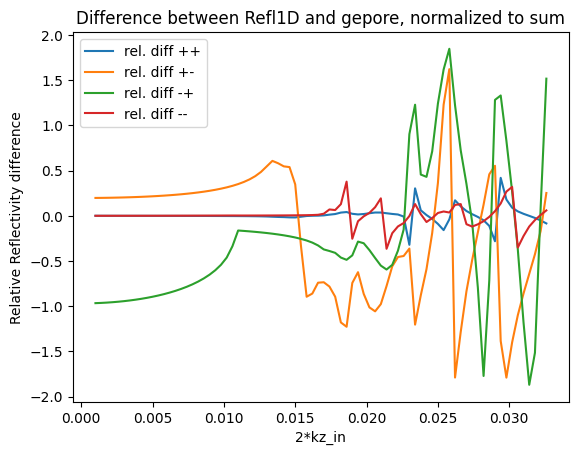

In [151]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i, label in enumerate(xs_labels):
    # if not i == 1 and not i == 2:  # skip +- and -+
    ax.plot(Qz, 2 * (R1[i] - Rg[i]) / np.abs(R1[i] + Rg[i]), label=f"rel. diff {label}")
ax.set_ylabel("Relative Reflectivity difference")
ax.set_xlabel("2*kz_in")
ax.set_title("Difference between Refl1D and gepore, normalized to sum")
ax.legend()